# Introduction
This is the implementation of Age and Gender Classification using ResNets in PyTorch as the deep learning framework. There are two networks used: ResNet18 and pretrained ResNet18 with ImageNet dataset.

## Mounting the drive

In [1]:
from google.colab import drive
drive.mount('/content/gdrive' )

Mounted at /content/gdrive


## Imports

In [1]:
import torch
import torch.autograd.variable as Variable
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torchvision.utils as utils
from torch.utils.data import Dataset, DataLoader

In [2]:
import numpy as np
import os
import matplotlib.pyplot as plt
from PIL import Image
from shutil import copyfile
from tqdm.notebook import tqdm

# Preparing dataloaders

## Data loading

In [3]:
PATH_TO_FOLDS = "./train_val_txt_files_per_fold"
# PATH_TO_DATA = "/content/gdrive/My Drive/AgeGenderClassification/data"
PATH_TO_IMAGE_FOLDERS = "./aligned"

### Creating a Dataset class

We create a class **`AdienceDataset`** that extends **`Dataset`**. This class helps us in feeding the input data to the network in minibatches.



In [4]:
class AdienceDataset(Dataset):
    
    def __init__(self, txt_file, root_dir, transform):
        self.txt_file = txt_file
        self.root_dir = root_dir
        self.transform = transform
        self.data = self.read_from_txt_file()
    
    def __len__(self):
        return len(self.data)

    def read_from_txt_file(self):
        data = []
        f = open(self.txt_file)
        for line in f.readlines():
            image_file, label = line.split()
            label = int(label)
            if 'gender' in self.txt_file:
                label += 8
            data.append((image_file, label))
        return data
    
    def __getitem__(self, idx):
        img_name, label = self.data[idx]
        image = Image.open(self.root_dir + '/' + img_name)
        
        if self.transform:
            image = self.transform(image)
            
        return {
            'image': image,
            'label': label
        }         

### Transforms
Every image is first resized to a `256x256` image and then cropped to a `227x227` image before being fed to the network.

**`transforms_list`** is the list of transforms we would like to apply to the input data. Apart from training the neural network without any transformations, we can also train the network using the following transforms (also called as data augmentation techniques):
*   random horizontal flip
*   random crop and random horizontal flip

We don't perform any transformation on the images during validation and testing.


In [5]:
transforms_list = [
    transforms.Resize(256),
    transforms.CenterCrop(227),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.RandomCrop(227)
]

transforms_dict = {
    'train': {
        0: list(transforms_list[i] for i in [0, 1, 3]),        # no transformation
        1: list(transforms_list[i] for i in [0, 1, 2, 3]),     # random horizontal flip
        2: list(transforms_list[i] for i in [0, 4, 2, 3])      # random crop and random horizontal flip
    },
    'val': {
        0: list(transforms_list[i] for i in [0, 1, 3])
    },
    'test': {
        0: list(transforms_list[i] for i in [0, 1, 3])
    }
}

### Dataloader
The **`DataLoader`** class in PyTorch helps us iterate through the dataset. This is where we input **`minibatch_size`** to our algorithm.

In [6]:
def get_dataloader(s, c, fold, transform_index, minibatch_size):
    """
    Args:
        s: A string. Equals either "train", "val", or "test".
        c: A string. Equals either "age" or "gender".
        fold: An integer. Lies in the range [0, 4] as there are five folds present.
        transform_index: An integer. The transforms in the list correesponding
            to this index in the dictionary will be applied on the images.
        minibatch_size: An integer.

    Returns:
        An instance of the DataLoader class.
    """
    txt_file = f'{PATH_TO_FOLDS}/test_fold_is_{fold}/{c}_{s}.txt'
    root_dir = PATH_TO_IMAGE_FOLDERS
    
    transformed_dataset = AdienceDataset(txt_file, root_dir,
                                         transforms.Compose(transforms_dict[s][transform_index]))
    dataloader = DataLoader(transformed_dataset, batch_size=minibatch_size, shuffle=True)
    
    return dataloader

# Network

#### Create a torch device object

In [7]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [8]:
device

device(type='cuda', index=0)

In [9]:
PATH_TO_MODELS = "./models"

## Defining the network
The following is the code for building Basic Blocks in ResNet18.

In [10]:
class Block(nn.Module):
    
    def __init__(self, in_channels, out_channels, identity_downsample=None, stride=1):
        super(Block, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.identity_downsample = identity_downsample
        
    def forward(self, x):
        identity = x
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        if self.identity_downsample is not None:
            identity = self.identity_downsample(identity)
        x += identity
        x = self.relu(x)
        return x

### ResNet Module

The entire ResNet18 architecture will consist of the BasicBlock
layers. All the additional layers and logic will go into the ResNet
module. This is going to be the final module that will combine everything to build the ResNet18 model.

The following code block contains the code for the ResNet
module.

In [11]:
class Net(nn.Module):
    
    def __init__(self, image_channels, num_classes):
        
        super(Net, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(image_channels, 64, kernel_size=7, stride=2, padding=3)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        #resnet layers
        self.layer1 = self.__make_layer(64, 64, stride=1)
        self.layer2 = self.__make_layer(64, 128, stride=2)
        self.layer3 = self.__make_layer(128, 256, stride=2)
        self.layer4 = self.__make_layer(256, 512, stride=2)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)
        
    def __make_layer(self, in_channels, out_channels, stride):
        
        identity_downsample = None
        if stride != 1:
            identity_downsample = self.identity_downsample(in_channels, out_channels)
            
        return nn.Sequential(
            Block(in_channels, out_channels, identity_downsample=identity_downsample, stride=stride), 
            Block(out_channels, out_channels)
        )
        
    def forward(self, x):
        
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x = self.avgpool(x)
        x = x.view(x.shape[0], -1)
        x = self.fc(x)
        return x 
    
    def identity_downsample(self, in_channels, out_channels):
        
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1), 
            nn.BatchNorm2d(out_channels)
        )

In [13]:
net = Net(3, 10).to(device)

In [12]:
net = Net().to(device)

In [20]:
criterion = nn.CrossEntropyLoss()

# Running Pretrained PyTorch ResNet Models

Finetuning the ConvNet: Instead of random initialization, we initialize the network with a pretrained network, like the one that is trained on imagenet 1000 dataset. Rest of the training looks as usual.

In [36]:
import torchvision.models as models
resnet18 = models.resnet18(pretrained = True).to(device)

c:\Users\ujjwa\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
c:\Users\ujjwa\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [45]:
#25 epochs
resnet18_25EP = models.resnet18(pretrained = True).to(device) 

c:\Users\ujjwa\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
c:\Users\ujjwa\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## Hyperparameters


In [15]:
minibatch_size = 50
num_epochs = 30 #initially 60
lr = 0.0001  # initial learning rate

In [103]:
def validate(net, dataloader):
    net.eval()
    total_loss = 0
    with torch.no_grad():
        for i, batch in enumerate(dataloader):
            images, labels = batch['image'].to(device), batch['label'].to(device)
            outputs = net(images)
            loss = criterion(outputs, labels)
            total_loss += float(loss.item())

    return total_loss/(i+1)

## Training the network
We compute the loss on validation set and training set after every **epoch**. We decrease the learning by a tenth after 10,000 iterations using the **`MultiStepLR`** class of PyTorch.

In [102]:
def train(net, train_dataloader, epochs, val_dataloader=None):
    """
    Args:
        net: An instance of PyTorch's Net class.
        train_dataloader: An instance of PyTorch's Dataloader class.
        epochs: An integer.
        val_dataloader: An instance of PyTorch's Dataloader class.
    
    Returns:
        net: An instance of PyTorch's Net class. The trained network.
        training_loss: A list of numbers that represents the training loss at each checkpoint.
        validation_loss: A list of numbers that represents the validation loss at each checkpoint.
    """
    net.train()
    optimizer = optim.Adam(net.parameters(), lr)
    scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10000])
    
    training_loss, validation_loss = [], []
    
    for epoch in tqdm(range(epochs)):
        
        for  batch in tqdm((train_dataloader)):
            scheduler.step()
            optimizer.zero_grad()
            
            images, labels = batch['image'].to(device), batch['label'].to(device)
            # print(images.shape)
            outputs = net(images)
            # print(outputs)
            loss = criterion(outputs, labels)
            # print(loss)
            
            loss.backward()
            optimizer.step()
 
        
        print("0")    
        training_loss.append(validate(net, train_dataloader))   
        print("1")     
        validation_loss.append(validate(net, val_dataloader)) 
        print(f'epoch:{epoch}, training_error:{training_loss[-1]}, validation_error:{validation_loss[-1]}')

    return net, training_loss, validation_loss

ResNet18 - Age FOLD 1, 30 epochs

In [ ]:
# FOLD 1 AGE  30 epochs
net1 = Net().to(device)
train_dl_fold1 = get_dataloader("train", "age", 1, 2, 50)
val_dl_fold1 =  get_dataloader("val", "age", 1, 0, 50)
test_dl_fold1 =  get_dataloader("test", "age", 1, 0, 50)
net1, training_loss_fold1, validation_loss_fold1 = train(net1, train_dl_fold1, 30, "model1", 2, val_dl_fold1)

In [ ]:
testing_acc_fold1 = test(net1, test_dl_fold1, "age")

In [ ]:
testing_acc_fold1 


{'exact_match': 1720, 'total': 3101}

In [117]:
print(f'Age exact_match accuracy for fold 0 : {testing_acc_fold1["exact_match"]/testing_acc_fold1["total"]}')
print(f'Age one_off_match  accuracy for fold 0 : {testing_acc_fold1["exact_match"]/testing_acc_fold1["total"]}')

Age exact_match accuracy for fold 0 : 0.5946597871654305
Age one_off_match accuracy for fold 0 : 0.8791751621872104


 FOLD 0 pretrained resnet 60 EPOCHS


In [ ]:
# FOLD 0 pretrained resnet 60 EPOCHS
train_dl_fold0 = get_dataloader("train", "age", 0, 2, 50)
val_dl_fold0 =  get_dataloader("val", "age", 0, 0, 50)
test_dl_fold0 =  get_dataloader("test", "age", 0, 0, 50)
resnet18, preresnet_training_loss_fold0, preresnet_validation_loss_fold0 = train(resnet18, train_dl_fold0, 60, "model", 2, val_dl_fold0)

In [42]:
resnet18_testing_acc_fold0 = test(resnet18, test_dl_fold0, "age")

In [43]:
resnet18_testing_acc_fold0

{'exact_match': 2825, 'total': 4316, 'one_off_match': 4067}

In [86]:
print(f'Age exact_match accuracy for fold 0 : {resnet18_testing_acc_fold0["exact_match"]/resnet18_testing_acc_fold0["total"]}')
print(f'Age one_off_match accuracy for fold 0 : {resnet18_testing_acc_fold0["one_off_match"]/resnet18_testing_acc_fold0["total"]}')


Age exact_match accuracy for fold 0 : 0.6123725671918443
Age one_off_match accuracy for fold 0 : 0.9091751621872104


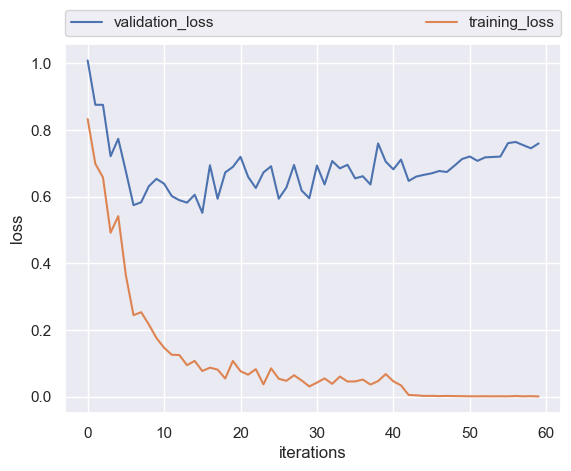

In [44]:
import seaborn as sns
sns.set_theme()
plt.plot( preresnet_validation_loss_fold0, label='validation_loss')
plt.plot( preresnet_training_loss_fold0, label='training_loss')
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
       ncol=2, mode="expand", borderaxespad=0.)
plt.xlabel('iterations')
plt.ylabel('loss')
plt.show()

 FOLD 0 pretrained resnet 25 EPOCHS


In [46]:
# FOLD 0 pretrained resnet 25 EPOCHS
train_dl_fold0 = get_dataloader("train", "age", 0, 2, 50)
val_dl_fold0 =  get_dataloader("val", "age", 0, 0, 50)
test_dl_fold0 =  get_dataloader("test", "age", 0, 0, 50)
resnet18_25EP, preresnet_training_loss_fold0_25EP, preresnet_validation_loss_fold0_25EP = train(resnet18_25EP, train_dl_fold0, 25, "model", 2, val_dl_fold0)

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/237 [00:00<?, ?it/s]

c:\Users\ujjwa\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\optim\lr_scheduler.py:131: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


0
1
epoch:0, training_error:0.7533872141365261, validation_error:0.9393001428017249


  0%|          | 0/237 [00:00<?, ?it/s]

0
1
epoch:1, training_error:0.6973309998522328, validation_error:0.8649503176028912


  0%|          | 0/237 [00:00<?, ?it/s]

0
1
epoch:2, training_error:0.6200302111197121, validation_error:0.8346183506342081


  0%|          | 0/237 [00:00<?, ?it/s]

0
1
epoch:3, training_error:0.5970357729412835, validation_error:0.7873916534277109


  0%|          | 0/237 [00:00<?, ?it/s]

0
1
epoch:4, training_error:0.3572352119890446, validation_error:0.6190029692191344


  0%|          | 0/237 [00:00<?, ?it/s]

0
1
epoch:5, training_error:0.3713355997443702, validation_error:0.6797823183811628


  0%|          | 0/237 [00:00<?, ?it/s]

0
1
epoch:6, training_error:0.23871585861917285, validation_error:0.5940495752371274


  0%|          | 0/237 [00:00<?, ?it/s]

0
1
epoch:7, training_error:0.34813704703176074, validation_error:0.8402496255361117


  0%|          | 0/237 [00:00<?, ?it/s]

0
1
epoch:8, training_error:0.24256965712907444, validation_error:0.6834210971227059


  0%|          | 0/237 [00:00<?, ?it/s]

0
1
epoch:9, training_error:0.1602893196486471, validation_error:0.5485450430558279


  0%|          | 0/237 [00:00<?, ?it/s]

0
1
epoch:10, training_error:0.12143334383262863, validation_error:0.6025100040894288


  0%|          | 0/237 [00:00<?, ?it/s]

0
1
epoch:11, training_error:0.11177637572655698, validation_error:0.5537136535231884


  0%|          | 0/237 [00:00<?, ?it/s]

0
1
epoch:12, training_error:0.10748920504805408, validation_error:0.5773334463055317


  0%|          | 0/237 [00:00<?, ?it/s]

0
1
epoch:13, training_error:0.09559985846752607, validation_error:0.6622624761210039


  0%|          | 0/237 [00:00<?, ?it/s]

0
1
epoch:14, training_error:0.1120582933101473, validation_error:0.6039013753716762


  0%|          | 0/237 [00:00<?, ?it/s]

0
1
epoch:15, training_error:0.07301046076438976, validation_error:0.6032363033065429


  0%|          | 0/237 [00:00<?, ?it/s]

0
1
epoch:16, training_error:0.12230444404017574, validation_error:0.7533718783121842


  0%|          | 0/237 [00:00<?, ?it/s]

0
1
epoch:17, training_error:0.06571291725029423, validation_error:0.631536080287053


  0%|          | 0/237 [00:00<?, ?it/s]

0
1
epoch:18, training_error:0.06435184987096847, validation_error:0.5962834942799348


  0%|          | 0/237 [00:00<?, ?it/s]

0
1
epoch:19, training_error:0.13089124017438306, validation_error:0.8657061961980966


  0%|          | 0/237 [00:00<?, ?it/s]

0
1
epoch:20, training_error:0.14679012962377272, validation_error:0.7690648098404591


  0%|          | 0/237 [00:00<?, ?it/s]

0
1
epoch:21, training_error:0.05695338426000647, validation_error:0.6658826590730593


  0%|          | 0/237 [00:00<?, ?it/s]

0
1
epoch:22, training_error:0.06044118956737377, validation_error:0.724022701382637


  0%|          | 0/237 [00:00<?, ?it/s]

0
1
epoch:23, training_error:0.05171604467288666, validation_error:0.7169920538480465


  0%|          | 0/237 [00:00<?, ?it/s]

0
1
epoch:24, training_error:0.09727346559176968, validation_error:0.7497126505925105


In [ ]:
import pickle

with open('age_training_loss_fold0.pickle', 'wb') as f:
    pickle.dump(resnet_training_loss_fold0, f)

with open('age_validation_loss_fold0.pickle', 'wb') as f:
    pickle.dump(resnet_validation_loss_fold0, f)  

Graph Plot 

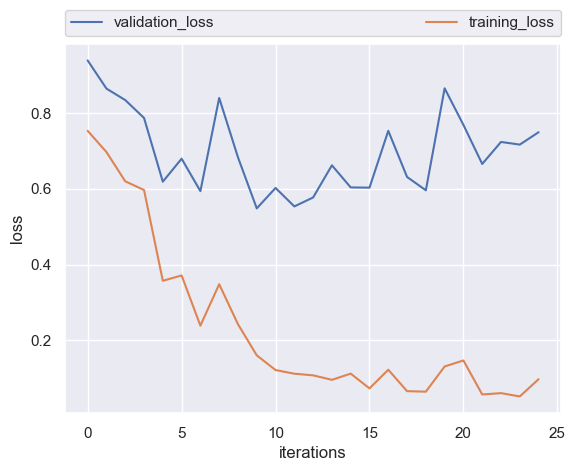

In [49]:
import seaborn as sns
sns.set_theme()
plt.plot( preresnet_validation_loss_fold0_25EP, label='validation_loss')
plt.plot( preresnet_training_loss_fold0_25EP, label='training_loss')
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
       ncol=2, mode="expand", borderaxespad=0.)
plt.xlabel('iterations')
plt.ylabel('loss')
plt.show()

In [50]:
pre_resnet_testing_acc_fold0_25EP = test(resnet18_25EP, test_dl_fold0, "age")

In [51]:
pre_resnet_testing_acc_fold0_25EP

{'exact_match': 2643, 'total': 4316, 'one_off_match': 3924}

In [87]:
print(f'Age exact_match accuracy for fold 0 : {pre_resnet_testing_acc_fold0_25EP["exact_match"]/pre_resnet_testing_acc_fold0_25EP["total"]}')
print(f'Age one_off_match accuracy for fold 0 : {pre_resnet_testing_acc_fold0_25EP["one_off_match"]/pre_resnet_testing_acc_fold0_25EP["total"]}')


Age exact_match accuracy for fold 0 : 0.6545412418906394
Age one_off_match accuracy for fold 0 : 0.9423076923076923


In [25]:
import pickle

with open('age_training_loss_fold0.pickle', 'wb') as f:
    pickle.dump(resnet_training_loss_fold0, f)

with open('age_validation_loss_fold0.pickle', 'wb') as f:
    pickle.dump(resnet_validation_loss_fold0, f)    

# Testing
We evaluate the performance (in terms of accuracy) of the trained network on the test set.

In [39]:
def test(net, dataloader, c):
    result = {
        'exact_match': 0,
        'total': 0
    }
    if c == 'age':
        result['one_off_match'] = 0

    with torch.no_grad():
        net.eval()
        for i, batch in enumerate(dataloader):
            images, labels = batch['image'].to(device), batch['label'].to(device)
            outputs = net(images)
            outputs = torch.tensor(list(map(lambda x: torch.max(x, 0)[1], outputs))).to(device)
            result['total'] += len(outputs)
            result['exact_match'] += sum(outputs == labels).item()
            if c == 'age':
                result['one_off_match'] += (sum(outputs==labels) +
                                            sum(outputs==labels-1) +
                                            sum(outputs==labels+1)).item()

    return result     

In [30]:
resnet_testing_acc_fold0 = test(net, test_dl_fold0, "age")

In [32]:
resnet_testing_acc_fold0

{'exact_match': 2221, 'total': 4316, 'one_off_match': 3577}

GENDER FOLDS

In [107]:
# FOLD 0
resnet18_gen = models.resnet18(pretrained = True).to(device)
gen_train_dl_fold0 = get_dataloader("train", "gender", 0, 2, 50)
gen_val_dl_fold0 =  get_dataloader("val", "gender", 0, 0, 50)
gen_test_dl_fold0 =  get_dataloader("test", "gender", 0, 0, 50)
resnet18_gen, pre_res_gen_training_loss_fold0, pre_res_gen_validation_loss_fold0 = train(resnet18_gen, gen_train_dl_fold0, 60, gen_val_dl_fold0)

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/246 [00:00<?, ?it/s]

0
1
epoch:0, training_error:0.16171357365764252, validation_error:0.18267736032053275


  0%|          | 0/246 [00:00<?, ?it/s]

0
1
epoch:1, training_error:0.1981796049399347, validation_error:0.1940491376099763


  0%|          | 0/246 [00:00<?, ?it/s]

0
1
epoch:2, training_error:0.140398988401805, validation_error:0.1475025001499388


  0%|          | 0/246 [00:00<?, ?it/s]

0
1
epoch:3, training_error:0.34310238702389284, validation_error:0.3565921860712546


  0%|          | 0/246 [00:00<?, ?it/s]

0
1
epoch:4, training_error:0.13223043878418886, validation_error:0.17975552925081165


  0%|          | 0/246 [00:00<?, ?it/s]

0
1
epoch:5, training_error:0.07973375627240999, validation_error:0.10500198292235534


  0%|          | 0/246 [00:00<?, ?it/s]

0
1
epoch:6, training_error:0.08255254261278949, validation_error:0.13839284068456403


  0%|          | 0/246 [00:00<?, ?it/s]

0
1
epoch:7, training_error:0.07246612756308622, validation_error:0.13788368559821887


  0%|          | 0/246 [00:00<?, ?it/s]

0
1
epoch:8, training_error:0.09173669318509538, validation_error:0.1460745946538669


  0%|          | 0/246 [00:00<?, ?it/s]

0
1
epoch:9, training_error:0.04497134874241684, validation_error:0.08097882955162614


  0%|          | 0/246 [00:00<?, ?it/s]

0
1
epoch:10, training_error:0.04078746630670124, validation_error:0.10206954395053564


  0%|          | 0/246 [00:00<?, ?it/s]

0
1
epoch:11, training_error:0.039275733680687694, validation_error:0.11258078344097291


  0%|          | 0/246 [00:00<?, ?it/s]

0
1
epoch:12, training_error:0.03254255190930837, validation_error:0.09476580427683613


  0%|          | 0/246 [00:00<?, ?it/s]

0
1
epoch:13, training_error:0.14205644971395776, validation_error:0.21218423090047306


  0%|          | 0/246 [00:00<?, ?it/s]

0
1
epoch:14, training_error:0.04047716534043458, validation_error:0.100537114198906


  0%|          | 0/246 [00:00<?, ?it/s]

0
1
epoch:15, training_error:0.05063359463981133, validation_error:0.1042779675098481


  0%|          | 0/246 [00:00<?, ?it/s]

0
1
epoch:16, training_error:0.018580725988679814, validation_error:0.11426244729577943


  0%|          | 0/246 [00:00<?, ?it/s]

0
1
epoch:17, training_error:0.01762505801114428, validation_error:0.09385887341987756


  0%|          | 0/246 [00:00<?, ?it/s]

0
1
epoch:18, training_error:0.05219812033228516, validation_error:0.13146926324676583


  0%|          | 0/246 [00:00<?, ?it/s]

0
1
epoch:19, training_error:0.018728674986642005, validation_error:0.08344813336238817


  0%|          | 0/246 [00:00<?, ?it/s]

0
1
epoch:20, training_error:0.025302576884883833, validation_error:0.12251228245872038


  0%|          | 0/246 [00:00<?, ?it/s]

0
1
epoch:21, training_error:0.02101845026106268, validation_error:0.10783213394245615


  0%|          | 0/246 [00:00<?, ?it/s]

0
1
epoch:22, training_error:0.017273942923847194, validation_error:0.1343905570468417


  0%|          | 0/246 [00:00<?, ?it/s]

0
1
epoch:23, training_error:0.01970229898314408, validation_error:0.1156237266043684


  0%|          | 0/246 [00:00<?, ?it/s]

0
1
epoch:24, training_error:0.03199326490644532, validation_error:0.16939936143656573


  0%|          | 0/246 [00:00<?, ?it/s]

0
1
epoch:25, training_error:0.013595293973742265, validation_error:0.09208512444187093


  0%|          | 0/246 [00:00<?, ?it/s]

0
1
epoch:26, training_error:0.024934663441802594, validation_error:0.1458022188809183


  0%|          | 0/246 [00:00<?, ?it/s]

0
1
epoch:27, training_error:0.060242417783805784, validation_error:0.1708188345828266


  0%|          | 0/246 [00:00<?, ?it/s]

0
1
epoch:28, training_error:0.03323725639205716, validation_error:0.15200775094261323


  0%|          | 0/246 [00:00<?, ?it/s]

0
1
epoch:29, training_error:0.07607867770754483, validation_error:0.19891968162523377


  0%|          | 0/246 [00:00<?, ?it/s]

0
1
epoch:30, training_error:0.013554794967862611, validation_error:0.11355697898263181


  0%|          | 0/246 [00:00<?, ?it/s]

0
1
epoch:31, training_error:0.006545293731247009, validation_error:0.11722742679045985


  0%|          | 0/246 [00:00<?, ?it/s]

0
1
epoch:32, training_error:0.0354514495323874, validation_error:0.15747752109611476


  0%|          | 0/246 [00:00<?, ?it/s]

0
1
epoch:33, training_error:0.03154578164005245, validation_error:0.1918310991798838


  0%|          | 0/246 [00:00<?, ?it/s]

0
1
epoch:34, training_error:0.06664691034021099, validation_error:0.20707319683774753


  0%|          | 0/246 [00:00<?, ?it/s]

0
1
epoch:35, training_error:0.00848548884516084, validation_error:0.12231017359428936


  0%|          | 0/246 [00:00<?, ?it/s]

0
1
epoch:36, training_error:0.03417717633017422, validation_error:0.11784355028497952


  0%|          | 0/246 [00:00<?, ?it/s]

0
1
epoch:37, training_error:0.07043893248736252, validation_error:0.22687611446060515


  0%|          | 0/246 [00:00<?, ?it/s]

0
1
epoch:38, training_error:0.006721061895441972, validation_error:0.09570702968199772


  0%|          | 0/246 [00:00<?, ?it/s]

0
1
epoch:39, training_error:0.009140546819046276, validation_error:0.15753970566395395


  0%|          | 0/246 [00:00<?, ?it/s]

0
1
epoch:40, training_error:0.006092430616056261, validation_error:0.09726935330965919


  0%|          | 0/246 [00:00<?, ?it/s]

0
1
epoch:41, training_error:0.0023979973393099085, validation_error:0.09491722161894561


  0%|          | 0/246 [00:00<?, ?it/s]

0
1
epoch:42, training_error:0.0015222757626372364, validation_error:0.10024776261437822


  0%|          | 0/246 [00:00<?, ?it/s]

0
1
epoch:43, training_error:0.001750362786028782, validation_error:0.09849395555297465


  0%|          | 0/246 [00:00<?, ?it/s]

0
1
epoch:44, training_error:0.0014679926464072476, validation_error:0.10091248472842078


  0%|          | 0/246 [00:00<?, ?it/s]

0
1
epoch:45, training_error:0.0011119032064981162, validation_error:0.10764150885451171


  0%|          | 0/246 [00:00<?, ?it/s]

0
1
epoch:46, training_error:0.0010344656336591343, validation_error:0.10496954522440555


  0%|          | 0/246 [00:00<?, ?it/s]

0
1
epoch:47, training_error:0.0009626999520464566, validation_error:0.10918052211679795


  0%|          | 0/246 [00:00<?, ?it/s]

0
1
epoch:48, training_error:0.0009267470411634896, validation_error:0.1114056588579573


  0%|          | 0/246 [00:00<?, ?it/s]

0
1
epoch:49, training_error:0.000697516909257533, validation_error:0.1098898533598037


  0%|          | 0/246 [00:00<?, ?it/s]

0
1
epoch:50, training_error:0.000947388836003831, validation_error:0.10863026350346074


  0%|          | 0/246 [00:00<?, ?it/s]

0
1
epoch:51, training_error:0.0012871328099343944, validation_error:0.10876906954426549


  0%|          | 0/246 [00:00<?, ?it/s]

0
1
epoch:52, training_error:0.0009163171933636019, validation_error:0.10942867139608889


  0%|          | 0/246 [00:00<?, ?it/s]

0
1
epoch:53, training_error:0.0011882644919322, validation_error:0.11747375287167314


  0%|          | 0/246 [00:00<?, ?it/s]

0
1
epoch:54, training_error:0.0017321178190191245, validation_error:0.11556201784090565


  0%|          | 0/246 [00:00<?, ?it/s]

0
1
epoch:55, training_error:0.000592143774613111, validation_error:0.11389781588055754


  0%|          | 0/246 [00:00<?, ?it/s]

0
1
epoch:56, training_error:0.0006591644846076538, validation_error:0.11871501199709235


  0%|          | 0/246 [00:00<?, ?it/s]

0
1
epoch:57, training_error:0.0005670270153545537, validation_error:0.1129602326147034


  0%|          | 0/246 [00:00<?, ?it/s]

0
1
epoch:58, training_error:0.0009030245299419771, validation_error:0.11919412985918354


  0%|          | 0/246 [00:00<?, ?it/s]

0
1
epoch:59, training_error:0.0014725210910017331, validation_error:0.12105311837297415


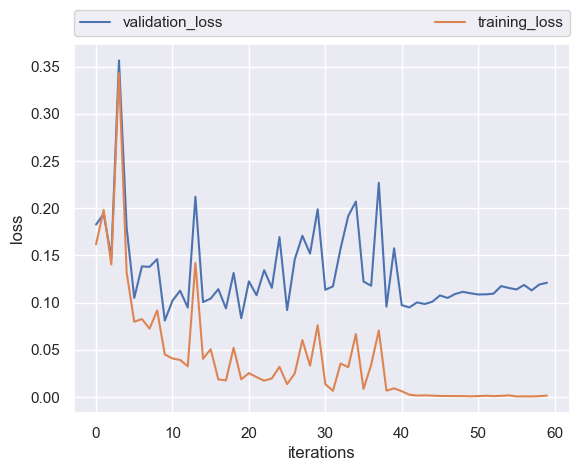

In [111]:
import seaborn as sns
sns.set_theme()
plt.plot( pre_res_gen_validation_loss_fold0, label='validation_loss')
plt.plot( pre_res_gen_training_loss_fold0, label='training_loss')
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
       ncol=2, mode="expand", borderaxespad=0.)
plt.xlabel('iterations')
plt.ylabel('loss')
plt.show()

In [109]:
with open('gen_training_loss_fold1.pickle', 'wb') as f:
    pickle.dump(pre_res_gen_training_loss_fold0, f)

with open('gen_validation_loss_fold1.pickle', 'wb') as f:
    pickle.dump(pre_res_gen_validation_loss_fold0, f)

In [112]:
pre_resnet_testing_acc_fold0 = test(resnet18_gen, gen_test_dl_fold0, "gender")

In [113]:
pre_resnet_testing_acc_fold0

{'exact_match': 3719, 'total': 4007}

In [114]:
print(f'Gender accuracy for fold 0 : {pre_resnet_testing_acc_fold0["exact_match"]/pre_resnet_testing_acc_fold0["total"]}')


Gender exact_match accuracy for fold 0 : 0.928125779885201


## Validation
We evaluate the performance (in terms of loss) of the trained network on validation set.

In [95]:
def validate(net, dataloader):
    net.eval()
    total_loss = 0
    with torch.no_grad():
        for i, batch in enumerate(dataloader):
            images, labels = batch['image'].to(device), batch['label'].to(device)
            outputs = net(images)
            loss = criterion(outputs, labels)
            total_loss += float(loss.item())

    return total_loss/(i+1)

## Saving the network

In [89]:
def save_network(net, filename):
    torch.save(net.state_dict(), f'{PATH_TO_MODELS}/{filename}.pt')

In [27]:
save_network(net, "resnet_age_fold0")

In [ ]:
save_network(net, "resnet_gen_fold0")

In [47]:
save_network(resnet18, "pretrained_resnet_age_fold0_60EP")

In [48]:
save_network(resnet18_25EP, "pretrained_resnet_age_fold0_25EP")

In [110]:
save_network(resnet18_gen, "pretrained_resnet_gen_fold0_25EP")

### Accuracy
These are the accurcies we get on **`age`**.

```
Fold 0 pretrained - 25 eps

{Age exact_match accuracy for fold 0 : 0.6545412418906394
, Age one_off_match accuracy for fold 0 : 0.9423076923076923}
```



## Gender

### Accuracy
This is the accuracy we get on  **`gender`**.

```
{'accuracy': 0.928125779885201}
```



# Testing on an image

In [90]:
mapping = {
    0: '0-2 years',
    1: '4-6 years',
    2: '8-13 years',
    3: '15-20 years',
    4: '25-32 years',
    5: '38-43 years',
    6: '48-53 years',
    7: '60 years and above',
    8: 'male',
    9: 'female'
}

In [57]:
def test_on_a_class(c, image_tensor, filename):
    with torch.no_grad():
        # net = Net().to(device)
        net = models.resnet18(pretrained = True).to(device)
        net.load_state_dict(torch.load(f'{PATH_TO_MODELS}/{filename}.pt'))
        net.eval()       
        output = net(image_tensor)
        output = torch.max(output, 1)[1].to(device)
        result = f'{c} = {mapping[output.item()]}'

    return result  

In [65]:
def test_age(path):
    image = Image.open(path)
    plt.imshow(image)
    image = transforms.Compose(transforms_dict['test'][0])(image)
    image.unsqueeze_(0)
    image = image.to(device)
    print(test_on_a_class('age', image, "pretrained_resnet_age_fold0_60EP"))
    # print(test_on_a_class('gender', image))

In [122]:
def test_gender(path):
    image = Image.open(path)
    plt.imshow(image)
    image = transforms.Compose(transforms_dict['test'][0])(image)
    image.unsqueeze_(0)
    image = image.to(device)
    print(test_on_a_class('gender', image, "pretrained_resnet_gen_fold0_25EP"))
    # print(test_on_a_class('gender', image))

## Examples

age = 4-6 years


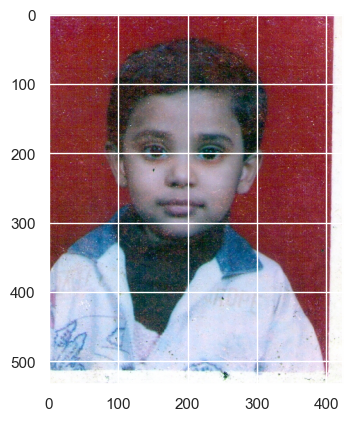

In [70]:
test_age("test1.jpg")

gender = male


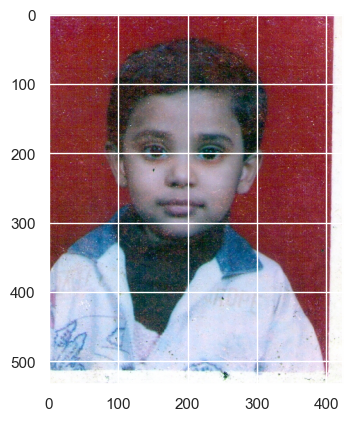

In [123]:
test_gender("test1.jpg")